# Adding sensors to Articulated Agents (Habitat-Lab 레벨 Tutorial)

Configuration

In [1]:
import git, os
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

### 1. Agent config에 넣어주는 방법

Agent Config를 만들어서, Config에 필요한 정보들을 넣어줍니다.  

In [2]:
from habitat.config.default_structured_configs import AgentConfig

# Agent config 정의
main_agent_config = AgentConfig()

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


1. 어떤 robot을 쓸 것인가?

In [3]:
urdf_path = os.path.join(data_path, "robots/hab_fetch/robots/hab_fetch.urdf")
main_agent_config.articulated_agent_urdf = urdf_path
main_agent_config.articulated_agent_type = "FetchRobot"

2. 어떤 sensor를 쓸 것인가?

In [4]:
from habitat.config.default_structured_configs import ThirdRGBSensorConfig, HeadRGBSensorConfig, HeadDepthSensorConfig, HeadPanopticSensorConfig
# Agent Config 속 Sensor 정의
main_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
    "head_depth": HeadDepthSensorConfig(),
    "head_panoptic": HeadPanopticSensorConfig()
}

config에 넘겨줘야 하기 때문에, dictionary로 정리

In [5]:
agent_dict = {"main_agent": main_agent_config}

Simulator Config를 만들어, Simulator에 지정해줄 정보들을 넣어주기  
1. type  
2. scene, scene_dataset, additional_object_paths 등  

In [6]:
import warnings
warnings.filterwarnings('ignore')
from omegaconf import OmegaConf

from habitat.config.default_structured_configs import SimulatorConfig

sim_cfg = SimulatorConfig(type="RearrangeSim-v0")

# This is for better graphics

sim_cfg.habitat_sim_v0.enable_hbao = True
sim_cfg.habitat_sim_v0.enable_physics = True

# Set up an example scene
# hssd-hab dataset 사용



# sim_cfg.scene = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json")
# sim_cfg.scene_dataset = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/hab3-hssd.scene_dataset_config.json")
# sim_cfg.additional_object_paths = [os.path.join(data_path, 'objects/ycb/configs/')]
# "scene_id": "106366386_174226770", 
# sim_cfg.scene = os.path.join(data_path, "hssd-hab/scenes-partnr-filtered/106366386_174226770.scene_instance.json") # 진짜 그 scene을 정의하는 json
sim_cfg.scene = "/data/hssd-hab/scenes-partnr-filtered/106366386_174226770.scene_instance.json" # 진짜 그 scene을 정의하는 json
sim_cfg.scene_dataset = "/data/hssd-hab/hssd-hab-partnr.scene_dataset_config.json" # 이외에 scene load에 필요한 데이터셋들 경로 저장
sim_cfg.additional_object_paths = ["/data/objects/ycb/configs/", 
                                   "/data/objects_ovmm/train_val/ai2thorhab/configs/objects", 
                                   "/data/objects_ovmm/train_val/amazon_berkeley/configs", 
                                   "/data/objects_ovmm/train_val/google_scanned/configs", 
                                   "/data/objects_ovmm/train_val/hssd/configs/objects"] # 추가 objects 경로
# main scene config를 cfg로 만들기
cfg = OmegaConf.create(sim_cfg)

In [7]:
print(cfg)

{'type': 'RearrangeSim-v0', 'forward_step_size': 0.25, 'turn_angle': 10, 'create_renderer': False, 'requires_textures': True, 'auto_sleep': False, 'step_physics': True, 'concur_render': False, 'needs_markers': True, 'update_articulated_agent': True, 'scene': '/data/hssd-hab/scenes-partnr-filtered/106366386_174226770.scene_instance.json', 'scene_dataset': '/data/hssd-hab/hssd-hab-partnr.scene_dataset_config.json', 'additional_object_paths': ['/data/objects/ycb/configs/', '/data/objects_ovmm/train_val/ai2thorhab/configs/objects', '/data/objects_ovmm/train_val/amazon_berkeley/configs', '/data/objects_ovmm/train_val/google_scanned/configs', '/data/objects_ovmm/train_val/hssd/configs/objects'], 'seed': '${habitat.seed}', 'default_agent_id': 0, 'debug_render': False, 'debug_render_articulated_agent': False, 'kinematic_mode': False, 'should_setup_semantic_ids': True, 'debug_render_goal': True, 'robot_joint_start_noise': 0.0, 'ctrl_freq': 120.0, 'ac_freq_ratio': 4, 'load_objs': True, 'hold_thr

main config에 sim 정보를 넣어주기

In [ ]:
import habitat_sim
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim
# from habitat_llm.sims.collaboration_sim import CollaborationSim

# main scene config에 agent_dict 넣기
cfg.agents = agent_dict
cfg.agents_order = list(cfg.agents.keys())

# Sim 만들기
print("creating sim")
sim = RearrangeSim(cfg)
print("sim created")

# Agent Initialization 시키기
sim.agents_mgr.on_new_scene()

### 2. Simulation Initialization 이후 Sensor 추가로 달기  
modification

In [9]:
# 아까 단 카메라 외에 다른 방법으로 카메라를 추가할 수도 있음
# 예시에선 scene_camera_rgb
camera_sensor_spec = habitat_sim.CameraSensorSpec()
camera_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
camera_sensor_spec.uuid = "scene_camera_rgb"

# # TODO: this is a bit dirty but I think its nice as it shows how to modify a camera sensor...
sim.add_sensor(camera_sensor_spec, 0)

Scene - Agent default info 설정해주기  
1. scene에서 agent base 위치  
2. 어떤 Motion을 쓰는 지?

In [10]:
import magnum as mn
from habitat_sim.physics import MotionType

init_pos = mn.Vector3(-5.5,0,-1.5)
art_agent = sim.articulated_agent
art_agent.sim_obj.motion_type = MotionType.KINEMATIC # 어떤 모션을 쓸 것인지?
art_agent.base_pos = init_pos # base_pos를 설정해줍니다.

obs, reward, done, info = sim.step(action)  
의 기본 틀을 통해 simulation에서 agent가 step합니다.  

In [11]:
# update를 위해선 sim.step을 사용해줍니다. (이런 식으로 config를 바꿔주고, 그 바뀐 config를 사용해서 다음 step을 만들어줘야 할 것 같습니다.)
_ = sim.step({})
print(_.keys())

dict_keys(['third_rgb', 'head_rgb', 'head_depth', 'head_panoptic'])


scene_camera는 agent와 무관하기 때문에, step엔 잡히지 않고, sim 단에서 가져올 수 있음

In [12]:
observations = sim.get_sensor_observations()
print(observations.keys())

dict_keys(['third_rgb', 'head_rgb', 'head_depth', 'head_panoptic', 'scene_camera_rgb'])


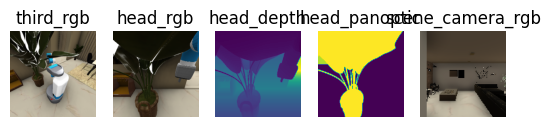

In [13]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,len(observations.keys()))

for ind, name in enumerate(observations.keys()):
    ax[ind].imshow(observations[name])
    ax[ind].set_axis_off()
    ax[ind].set_title(name)

In [14]:
art_agent.params.cameras.keys()

dict_keys(['articulated_agent_arm', 'head', 'third'])

임의 방향으로 robot을 움직여보겠습니다.

In [20]:
import numpy as np
import habitat_sim.utils.viz_utils as vut

observations = []
num_iter = 1000
pos_delta = mn.Vector3(0.02,0,0)
rot_delta = np.pi / (8 * num_iter)
art_agent.base_pos = init_pos

# sim.reset()
# set_fixed_camera(sim)
for _ in range(num_iter):
    # TODO: this actually seems to give issues...
    art_agent.base_pos = art_agent.base_pos + pos_delta
    art_agent.base_rot = art_agent.base_rot + rot_delta
    sim.step({})
    observations.append(sim.get_sensor_observations())

Head에 달린 3개의 RGB, Panoptic, Depth 센서를 확인해보겠습니다.  
각각 option을 맞게 설정해줘야 합니다.

In [22]:
vut.make_video(
    observations,
    "head_rgb",
    "color",
    "robot_tutorial_video_head_rgb.mp4",
    open_vid=True,
)
vut.make_video(
    observations,
    "head_panoptic",
    "semantic",
    "robot_tutorial_video_head_panoptic.mp4",
    open_vid=True,
)
vut.make_video(
    observations,
    "head_depth",
    "depth",
    "robot_tutorial_video_head_depth.mp4",
    open_vid=True,
)

Encoding the video: robot_tutorial_video_head_rgb.mp4 


Encoding the video: robot_tutorial_video_head_panoptic.mp4 


Encoding the video: robot_tutorial_video_head_depth.mp4 


이외의 3인칭 third_rgb와 CCTV같은 scene_camera_rgb도 찍어봅니다.  

In [23]:

vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video_third_rgb.mp4",
    open_vid=True,
)
vut.make_video(
    observations,
    "scene_camera_rgb",
    "color",
    "robot_tutorial_video_scene_camera_rgb.mp4",
    open_vid=True,
)

Encoding the video: robot_tutorial_video_third_rgb.mp4 


Encoding the video: robot_tutorial_video_scene_camera_rgb.mp4 


### 4. Test All the Sensors

### 상속구조 파악 필요
1. HabitatBaseConfig
2. SimulatorSensorConfig, PyrobotSensor, PyrobotSensorConfig
3-1. (SimulatorSensorConfig) SimulatorCameraSensorConfig, SimulatorDepthSensorConfig, SimulatorFisheyeSensorConfig
3-2. (PyrobotSensor) PyRobotVisualSensorConfig, PyRobotBumpSensorConfig
이와 같은 상속구조를 갖고 있음.  
이들을 기반으로 simulation을 찍도록 설정하면, SimulatorSimSensor류, Agent에 부착하면 AgentSensor류...

### CameraSensorConfig
- SimulatorCameraSensorConfig
    - HabitatSimRGBSensorConfig
        - HeadRGBSensorConfig
        - ArmRGBSensorConfig
        - JawRGBSensorConfig
        - ThirdRGBSensorConfig
    - HabitatSimDepthSensorConfig
        - HeadDepthSensorConfig
        - HeadStereoLeftDepthSensorConfig
        - HeadStereoRightDepthSensorConfig
        - ArmDepthSensorConfig
        - JawDepthSensorConfig
        - ThirdDepthSensorConfig
    - HabitatSimSemanticSensorConfig
        - HeadPanopticSensorConfig
        - ArmPanopticSensorConfig
        - JawPanopticSensorConfig

### DepthSensorConfig
- SimulatorDepthSensorConfig
    - HabitatSimEquirectangularDepthSensorConfig

### FisheyeSensorConfig
- SimulatorFisheyeSensorConfig
    - SimulatorFisheyeRGBSensorConfig
    - SimulatorFisheyeDepthSensorConfig
    - SimulatorFisheyeSemanticSensorConfig

### PyrobotVisualSensorConfig
- PyrobotVisualSensorConfig
    - PyrobotRGBSensorConfig
    - PyrobotDepthSensorConfig

### PyrobotBumpSensorConfig
- PyrobotBumpSensorConfig

위의 센서들이 존재하고, 이들을 아까와 같은 방법으로 부착할 수 있습니다.  